# CNN Model Template

This notebook is a template for building a CNN model.

## Imports and inital setup

In [31]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import sys

sys.path.append("..")
from helperfunctions import modelhelper as mh

SEED = 42
NUM_EPOCHS = 1

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL="dx"
BALANCE_LABEL="dx"
IMAGE_SIZE = (244, 244)

### Loading (augmented) metadata as test, train, validation from files

In [32]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
1750,HAM_0002738,ISIC_0029438.jpg,nv,histo,65.0,female,face,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0029438.jpg
7439,HAM_0007131,aug_oCQ0ApISIC_0031692.jpg,akiec,histo,60.0,male,back,rosendahl,skin_cancer,./../data/jpgs/aug_oCQ0ApISIC_0031692.jpg
1026,HAM_0004995,ISIC_0029869.jpg,nv,follow_up,45.0,female,upper extremity,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0029869.jpg
2711,HAM_0004536,aug_YLt1XWISIC_0030314.jpg,bcc,histo,40.0,female,back,vidir_modern,skin_cancer,./../data/jpgs/aug_YLt1XWISIC_0030314.jpg
912,HAM_0007553,ISIC_0031676.jpg,nv,histo,40.0,male,back,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0031676.jpg
802,HAM_0000615,ISIC_0026758.jpg,nv,follow_up,45.0,male,lower extremity,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0026758.jpg
13120,HAM_0004756,aug_RS0ZI0ISIC_0029248.jpg,df,histo,55.0,male,lower extremity,vienna_dias,not_skin_cancer,./../data/jpgs/aug_RS0ZI0ISIC_0029248.jpg
7528,HAM_0002441,aug_sAuUY4ISIC_0031381.jpg,akiec,histo,80.0,male,scalp,rosendahl,skin_cancer,./../data/jpgs/aug_sAuUY4ISIC_0031381.jpg
7548,HAM_0006746,aug_34xl1aISIC_0026872.jpg,akiec,histo,85.0,male,lower extremity,rosendahl,skin_cancer,./../data/jpgs/aug_34xl1aISIC_0026872.jpg
10469,HAM_0003179,ISIC_0029108.jpg,bkl,histo,35.0,female,face,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0029108.jpg


## Setting up the image data generator for training and validation

In [33]:
# Setting up the Image Data Generator for the train data set - including augmentation

datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1], important for CNNs to perform better, deactivate to see images down below
    preprocessing_function=preprocess_input,  # Use the preprocess_input function of MobileNetV3Large
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    preprocessing_function=preprocess_input
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=32
)

Found 2003 validated image filenames belonging to 7 classes.


Found 14006 validated image filenames belonging to 7 classes.


# Using MobileNet V3 large

In [34]:
PRETRAINED = False

if PRETRAINED:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top 
    x = layers.Conv2D(128, (3, 3), activation='relu')(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(7, activation='softmax')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_pretrained-weights_fixed-layers_custom-conv2D")

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

else:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Large(weights=None, include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = True

    # Add custom layers on top 
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(7, activation='softmax')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_rand-weights")

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    model.summary()


Model: "MobilneNetV3Large_rand-weights"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, 224, 224, 3)          0         ['input_9[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_8[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                           

## Model Training

In [35]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=None,                # Set the batch size, default is 32, can be increased to speed up training
    callbacks=None,                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

 27/438 [>.............................] - ETA: 14:41 - loss: 3.7445 - accuracy: 0.1759

## Plotting accuracy and loss of train and validation set

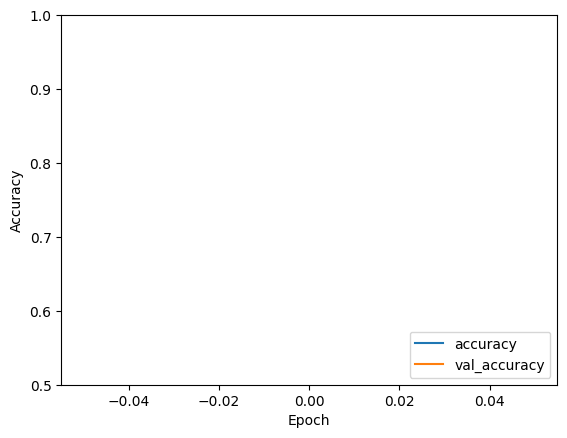

In [ ]:
mh.model_plot_accuracy(history)

## Evaluating the model on the test set

In [ ]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

63/63 - 2s - loss: 65.1376 - accuracy: 0.0704 - 2s/epoch - 36ms/step


## Saving the model

In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
